In [1]:
!pwd

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:96% !important; }</style>"))# デフォルトは75%

import sys
sys.executable

/c/Users/shingo/jupyter_notebook/tfgpu_py36_work/02_keras_py/experiment


'C:\\Users\\shingo\\Anaconda3\\envs\\tfgpu20\\python.exe'

# multilabel model

#### マルチラベルサンプルデータ
- https://blog.manash.me/multi-task-learning-in-keras-implementation-of-multi-task-classification-loss-f1d42da5c3f6
- classes = np.array(['desert', 'mountain', 'sea', 'sunset', 'trees'])


C:\Users\shingo\Anaconda3\envs\tfgpu20\lib\site-packages\ipykernel_launcher.py:11: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\shingo\Anaconda3\envs\tfgpu20\lib\site-packages\ipykernel_launcher.py:12: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  if sys.path[0] == '':
C:\Users\shingo\Anaconda3\envs\tfgpu20\lib\site-packages\ipykernel_launcher.py:13: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  del sys.path[0]


(1600, 100, 100, 3) (400, 100, 100, 3)
[[0 0 1 1 0]
 [0 0 1 0 0]
 [0 1 0 0 0]
 [0 0 1 1 0]
 [0 0 0 1 0]]


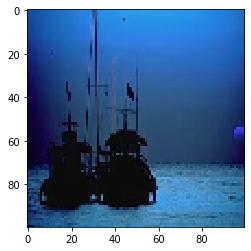

In [2]:
# Downloading and Viewing the dataset

import numpy as np
import matplotlib.pyplot as plt
import h5py
from sklearn.model_selection import train_test_split
#Jupyterでインライン表示するための宣言
%matplotlib inline

def load():
    f = h5py.File("01_code_test/dataset.h5")
    x = f['x'].value
    y = f['y'].value
    f.close()
    
    x_train , x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=100)
    
    # Making the data channel last
    x_train = np.rollaxis(x_train, 1, 4)
    x_test = np.rollaxis(x_test, 1, 4)
    
    # Normalizing data
    x_train = x_train  / 255.0
    x_test = x_test / 255.0
   
    return x_train, x_test, y_train, y_test

x_train, x_test, y_train, y_test = load()
print(x_train.shape, x_test.shape)
print(y_train[:5])
plt.imshow(x_train[0])

#### import

In [3]:
# モジュールimport
import os, sys
sys.path.append(r'C:\Users\shingo\jupyter_notebook\tfgpu_py36_work\02_keras_py')
from dataset import plot_log, util
from model import tf_define_model as define_model
from model import tf_my_callback as my_callback
from model import tf_lr_finder as lr_finder
from model import tf_multi_loss as multi_loss
from transformer import tf_my_generator as my_generator
from transformer import tf_get_train_valid_test as get_train_valid_test
from predicter import tf_grad_cam as grad_cam
from predicter import tf_base_predict as base_predict
from predicter import roc_curve, conf_matrix, ensemble_predict, pr_curve

from tensorflow import keras
keras.backend.clear_session()

import dill
import glob, time, pathlib
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
%reload_ext autoreload
%autoreload 2
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:96% !important; }</style>"))# 75%

#### parameters

In [4]:
# 出力ディレクトリ
output_dir = r'D:\work\kaggle_data\multi_label_test'
os.makedirs(output_dir, exist_ok=True)

gpu_num = 0# "0,1,2,3"

# 分類クラス
class_name = ['desert', 'mountain', 'sea', 'sunset', 'trees']
classes = class_name
nb_classes = len(classes)

# エポック数、バッチサイズ
num_epoch = 2
batch_size = 50
val_batch_size = 50
test_batch_size = 50

# 入力層のサイズ
img_rows, img_cols, channels = 100, 100, 3

# finetuning model
choice_model = 'VGG16'#'EfficientNet'#'InceptionV3'
trainable = 15#249#'all'
is_skip_bn = True
model_path = None

# 全結合層
fcs = [256]
drop = 0.5
is_add_batchnorm = True#False
l2_rate = 1e-4

# optimizer
choice_optim='sgd'
lr = 0.1 * batch_size / 128
lr_factor = 0.01
    
# data augmentation
rescale = 1.0/255.0
#width_shift_range = 0.2
#height_shift_range = 0.2
horizontal_flip = True
#vertical_flip = True
#shear_range = 20
zoom_range_min = 0.8
zoom_range_max = 1.2
rotation_range = 20
channel_shift_range = 5.
brightness_range_min = 0.3
brightness_range_max = 1.0
mix_up_alpha = 0.2# mixup alpha
#random_crop = [224,224]# random_crop size
random_erasing_prob = 0.5 # random_erasing 確率
random_erasing_maxpixel = 255
ricap_beta = 0.3 # RICAP beta
ricap_use_same_random_value_on_batch = True # Trueとすれば論文と同じように「ミニバッチ間で共通の乱数を使う例」。Falseにすれば、「サンプル間で別々の乱数を使う例」
is_base_aug = True # 下山さんが使っていたAutoAugmentのデフォルト？変換入れるか

In [5]:
# my_IDG_optionsに値詰める。papermillで実行した時でもうまくいくようにする

gpus = str(gpu_num)
zoom_range = [zoom_range_min, zoom_range_max]
brightness_range = [brightness_range_min, brightness_range_max]

my_IDG_options = {}
if 'rescale' in list(locals().keys()):
    my_IDG_options['rescale'] = rescale
        
if 'width_shift_range' in list(locals().keys()):
    my_IDG_options['width_shift_range'] = width_shift_range
    
if 'height_shift_range' in list(locals().keys()):
    my_IDG_options['height_shift_range'] = height_shift_range
    
if 'horizontal_flip' in list(locals().keys()):
    my_IDG_options['horizontal_flip'] = horizontal_flip
    
if 'vertical_flip' in list(locals().keys()):
    my_IDG_options['vertical_flip'] = vertical_flip
    
if 'shear_range' in list(locals().keys()):
    my_IDG_options['shear_range'] = shear_range
    
if 'zoom_range' in list(locals().keys()):
    my_IDG_options['zoom_range'] = zoom_range
    
if 'rotation_range' in list(locals().keys()):
    my_IDG_options['rotation_range'] = rotation_range

if 'channel_shift_range' in list(locals().keys()):
    my_IDG_options['channel_shift_range'] = channel_shift_range

if 'brightness_range' in list(locals().keys()):
    my_IDG_options['brightness_range'] = brightness_range    

if 'mix_up_alpha' in list(locals().keys()):
    my_IDG_options['mix_up_alpha'] = mix_up_alpha
    
if 'random_erasing_prob' in list(locals().keys()):
    my_IDG_options['random_erasing_prob'] = random_erasing_prob
    
if 'random_erasing_maxpixel' in list(locals().keys()):
    my_IDG_options['random_erasing_maxpixel'] = random_erasing_maxpixel

if 'ricap_beta' in list(locals().keys()):
    my_IDG_options['ricap_beta'] = ricap_beta
    
if 'ricap_use_same_random_value_on_batch' in list(locals().keys()):
    my_IDG_options['ricap_use_same_random_value_on_batch'] = ricap_use_same_random_value_on_batch
    
if 'is_base_aug' in list(locals().keys()):
    my_IDG_options['is_base_aug'] = is_base_aug

#### data generator

In [6]:
def check_gen(gen):
    """ generatorの画像確認 """
    from PIL import Image
    import matplotlib.pyplot as plt
    import numpy as np
    %matplotlib inline
    x,y = next(gen)
    if isinstance(y, list):
        y = np.array(y)
    print(f"x.shape: {x.shape}")
    print(f"y.shape: {y.shape}")
    print(f"x[0].max():{x[0].max()}")
    print(f"y[0]: {y[0]}")
    util.plot_5imgs(x)
    return x,y

In [7]:
d_cls = get_train_valid_test.LabeledDataset([img_rows, img_cols, channels]
                                            , batch_size, valid_batch_size=val_batch_size
                                            , train_samples=x_train.shape[0], valid_samples=x_test.shape[0])
d_cls.X_train = x_train*255.
d_cls.y_train = y_train.astype('float32')
d_cls.X_valid = x_test*255.
d_cls.y_valid = y_test.astype('float32') # float型にしないとtrainでエラーになる。train setのｙがfloatなので 
d_cls.create_my_generator_flow(my_IDG_options=my_IDG_options)
print('d_cls.shape:', d_cls.X_train.shape, d_cls.X_valid.shape)

train_steps_per_epoch : 32
valid_steps_per_epoch : 8
my_IDG_options: {'rescale': 0.00392156862745098, 'horizontal_flip': True, 'zoom_range': [0.8, 1.2], 'rotation_range': 20, 'channel_shift_range': 5.0, 'brightness_range': [0.3, 1.0], 'mix_up_alpha': 0.2, 'random_erasing_prob': 0.5, 'random_erasing_maxpixel': 255, 'ricap_beta': 0.3, 'ricap_use_same_random_value_on_batch': True, 'is_base_aug': True}
d_cls.shape: (1600, 100, 100, 3) (400, 100, 100, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


x.shape: (50, 100, 100, 3)
y.shape: (50, 5)
x[0].max():0.8467965580736878
y[0]: [0.97971118 0.98967997 0.01148013 0.98097467 0.00869894]
Num_Images:  50


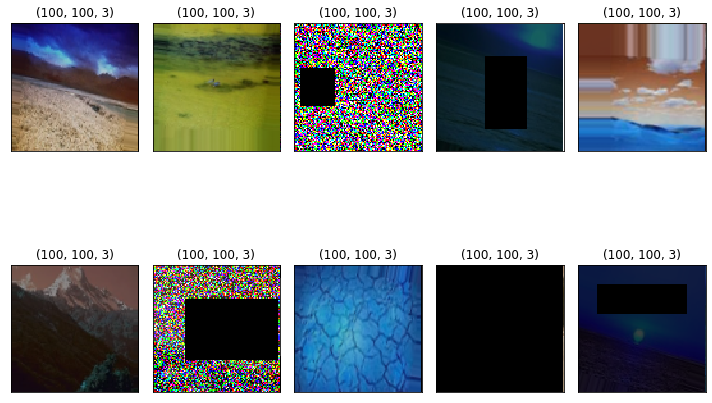

<Figure size 432x288 with 0 Axes>

In [8]:
x,y = check_gen(d_cls.train_gen)

x.shape: (50, 100, 100, 3)
y.shape: (50, 5)
x[0].max():0.9921569228172302
y[0]: [0. 0. 1. 0. 0.]
Num_Images:  50


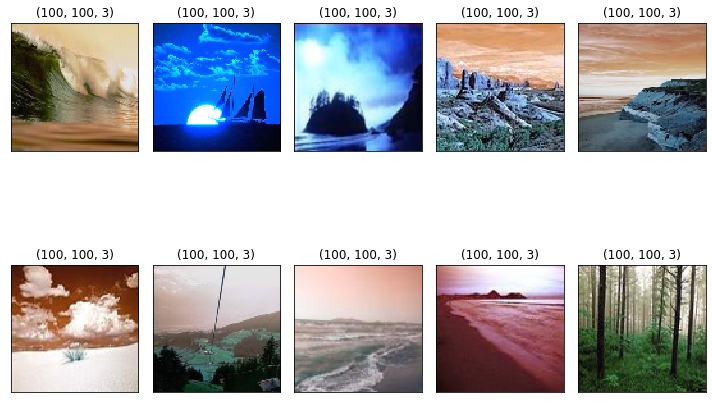

<Figure size 432x288 with 0 Axes>

In [9]:
x,y = check_gen(d_cls.valid_gen)

#### model

In [10]:
# loss
loss = multi_loss.build_masked_loss(keras.backend.binary_crossentropy)
metrics = ['binary_accuracy']
activation = 'sigmoid'

# model
if model_path is None:
    if trainable != 'all':
        trainable = int(trainable)
    model, orig_model = define_model.get_fine_tuning_model(output_dir, img_rows, img_cols, channels
                                                           , len(classes)
                                                           , choice_model, trainable
                                                           , fcs=fcs, drop=drop
                                                           , is_add_batchnorm=is_add_batchnorm
                                                           , l2_rate=l2_rate
                                                           , activation=activation
                                                           , gpu_count=len(gpus.split(','))
                                                           , skip_bn=is_skip_bn
                                                          )
else:
    model = keras.models.load_model(model_path, compile=False)
    
optim = define_model.get_optimizers(choice_optim, lr=lr)
model.compile(loss=loss, optimizer=optim, metrics=metrics)

----- model_param -----
output_dir = D:\work\kaggle_data\multi_label_test
img_rows img_cols channels = 100 100 3
num_classes = 5
choice_model trainable = VGG16 15
fcs = [256]
fcpool = GlobalAveragePooling2D
pred_kernel_initializer pred_l2_rate = zeros 0.0001
activation = sigmoid
gpu_count = 1
skip_bn = True
n_multitask = 1
----- FC_layers -----
dence dropout is_add_batchnorm kernel_initializer l2_rate = 256 0.5 True he_normal 0.0001
---- choice_optim = sgd ----
sgd_lr sgd_momentum sgd_decay sgd_nesterov = 0.0390625 0.9 0.0 True


In [11]:
define_model.print_model_summary(model)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0     

In [12]:
# 最適な学習率探索. 後続処理実行する場合はデータとモデル再定義必要
#lr_finder.run(model, d_cls.train_gen, batch_size, d_cls.init_train_steps_per_epoch, output_dir=output_dir)

#### train

Epoch 1/2
31/32 [============================>.] - ETA: 0s - loss: 0.6584 - binary_accuracy: 0.2414
Epoch 00001: val_loss improved from inf to 0.61797, saving model to D:\work\kaggle_data\multi_label_test\val_loss_best.h5

Epoch 00001: val_binary_accuracy improved from -inf to 0.75250, saving model to D:\work\kaggle_data\multi_label_test\val_accuracy_best.h5
32/32 [==============================] - 16s 488ms/step - loss: 0.6571 - binary_accuracy: 0.2376 - val_loss: 0.6180 - val_binary_accuracy: 0.7525
Epoch 2/2
31/32 [============================>.] - ETA: 0s - loss: 0.6155 - binary_accuracy: 0.2228
Epoch 00002: val_loss improved from 0.61797 to 0.61294, saving model to D:\work\kaggle_data\multi_label_test\val_loss_best.h5

Epoch 00002: val_binary_accuracy did not improve from 0.75250
32/32 [==============================] - 14s 428ms/step - loss: 0.6158 - binary_accuracy: 0.2194 - val_loss: 0.6129 - val_binary_accuracy: 0.7525
Elapsed Time : 29.32sec


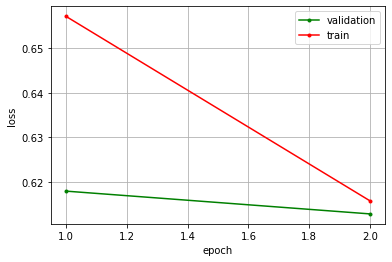

<Figure size 432x288 with 0 Axes>

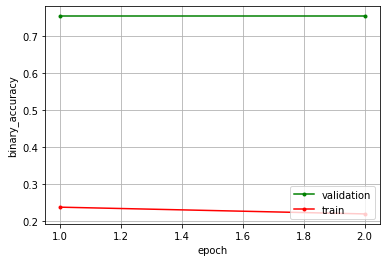

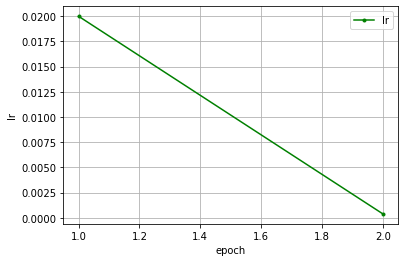

<Figure size 432x288 with 0 Axes>

In [13]:
def get_cb(output_dir:str, num_epoch:int) -> list:
    """ trainでつかうkerasのcallback取得 """
    cb = []
    # 学習率をエポック増やすごとにコサインカーブで上げ下げする. epochsはコサインカーブのほぼ半周期になるエポック数
    cb.append(my_callback.cosine_annealing(factor=lr_factor, epochs=num_epoch))
    # ログを保存するカスタムコールバック
    cb.append(my_callback.tsv_logger(os.path.join(output_dir, 'tsv_logger.tsv')))
    # epochごとに学習曲線保存する自作callback
    cb.append(my_callback.learning_curve_plot(os.path.join(output_dir, 'learning_curve.png')))
    # 各エポックでval_lossが最小となるモデル保存
    cb.append(keras.callbacks.ModelCheckpoint(filepath=os.path.join(output_dir, 'val_loss_best.h5'), monitor='val_loss', save_best_only=True, verbose=1))
    cb.append(keras.callbacks.ModelCheckpoint(filepath=os.path.join(output_dir, 'val_accuracy_best.h5'), monitor='val_binary_accuracy', save_best_only=True, verbose=1, mode='max'))
    # 過学習の抑制 <early_stopping_pati>step続けてval_loss減らなかったら打ち切る
    cb.append(keras.callbacks.EarlyStopping(monitor='val_loss', patience=num_epoch//2, verbose=1))
    return cb

start_time = time.time()
history = model.fit_generator(
    d_cls.train_gen
    , steps_per_epoch = d_cls.init_train_steps_per_epoch
    , epochs = num_epoch
    , validation_data = d_cls.valid_gen
    , validation_steps = d_cls.init_valid_steps_per_epoch
    , verbose = 1 # 1:ログをプログレスバーで標準出力 2:最低限の情報のみ出す
    , callbacks = get_cb(output_dir, num_epoch)
    )
end_time = time.time()
print("Elapsed Time : {:.2f}sec".format(end_time - start_time))

# lossやaccの学習履歴のグラフ保存
plot_log.plot_results(output_dir, os.path.join(output_dir, 'tsv_logger.tsv'), acc_metric=metrics[0])

#### predict

In [14]:
d_cls.test_gen, d_cls.X_test, d_cls.y_test = d_cls.valid_gen, d_cls.X_valid, d_cls.y_valid

,Filename,PredictionLabel,PredictionScore
0,2\none,trees,0.382
1,3\none,sea,0.407
2,2\none,trees,0.379
3,0\none,trees,0.364
4,2\none,trees,0.358


y_pred.shape: (400, 5)
------------------------------------
out_dir: D:\work\kaggle_data\multi_label_test\predict/test\confusion_matrix
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       316
           1       0.00      0.00      0.00        84
          -1       0.00      0.00      0.00         0

   micro avg       0.79      0.79      0.79       400
   macro avg       0.26      0.33      0.29       400
weighted avg       0.62      0.79      0.70       400

Confusion matrix, without normalization


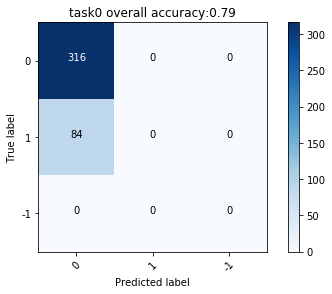

------------------------------------
out_dir: D:\work\kaggle_data\multi_label_test\predict/test\confusion_matrix
              precision    recall  f1-score   support

           0       0.76      1.00      0.87       305
           1       0.00      0.00      0.00        95
          -1       0.00      0.00      0.00         0

   micro avg       0.76      0.76      0.76       400
   macro avg       0.25      0.33      0.29       400
weighted avg       0.58      0.76      0.66       400

Confusion matrix, without normalization


<Figure size 432x288 with 0 Axes>

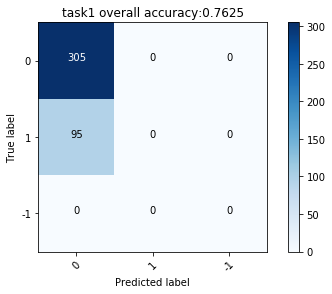

------------------------------------
out_dir: D:\work\kaggle_data\multi_label_test\predict/test\confusion_matrix
              precision    recall  f1-score   support

           0       0.74      0.98      0.84       297
           1       0.30      0.03      0.05       103
          -1       0.00      0.00      0.00         0

   micro avg       0.73      0.73      0.73       400
   macro avg       0.35      0.34      0.30       400
weighted avg       0.63      0.73      0.64       400

Confusion matrix, without normalization


<Figure size 432x288 with 0 Axes>

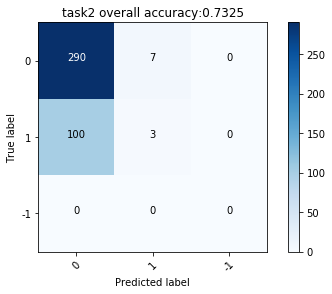

------------------------------------
out_dir: D:\work\kaggle_data\multi_label_test\predict/test\confusion_matrix
              precision    recall  f1-score   support

           0       0.78      1.00      0.88       313
           1       0.00      0.00      0.00        87
          -1       0.00      0.00      0.00         0

   micro avg       0.78      0.78      0.78       400
   macro avg       0.26      0.33      0.29       400
weighted avg       0.61      0.78      0.69       400

Confusion matrix, without normalization


<Figure size 432x288 with 0 Axes>

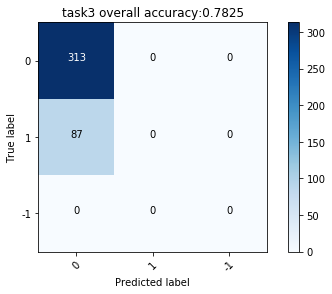

------------------------------------
out_dir: D:\work\kaggle_data\multi_label_test\predict/test\confusion_matrix
              precision    recall  f1-score   support

           0       0.69      1.00      0.81       274
           1       0.00      0.00      0.00       126
          -1       0.00      0.00      0.00         0

   micro avg       0.69      0.69      0.69       400
   macro avg       0.23      0.33      0.27       400
weighted avg       0.47      0.69      0.56       400

Confusion matrix, without normalization


<Figure size 432x288 with 0 Axes>

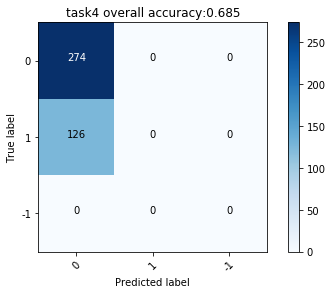

------------------------------------
out_png: D:\work\kaggle_data\multi_label_test\predict/test\ROC_curve.png
desert_roc_auc: 0.719296262808921
mountain_roc_auc: 0.481725625539258
sea_roc_auc: 0.6671570069628322
sunset_roc_auc: 0.8210495391281994
trees_roc_auc: 0.7099409106708376
mean_auc: 0.6800163473321427
std_auc: 0.11118737242265092


<Figure size 432x288 with 0 Axes>

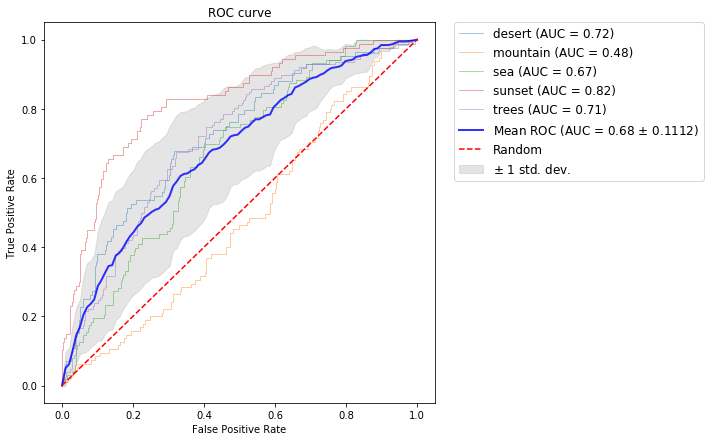

desert_roc_auc: 0.40761406829204616
mountain_roc_auc: 0.22907595844174478
sea_roc_auc: 0.3763389650853167
sunset_roc_auc: 0.602708459860058
trees_roc_auc: 0.49497933563982593
Average precision score, micro-averaged over all classes: 0.37075209


<Figure size 432x288 with 0 Axes>

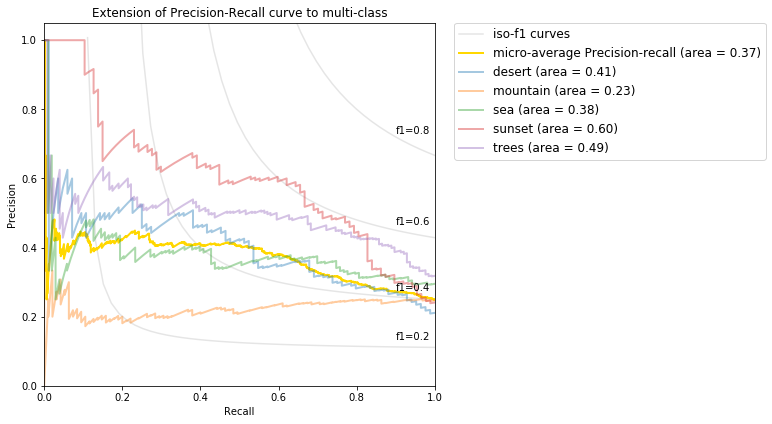

INFO: save file. [D:\work\kaggle_data\multi_label_test\predict/test\score\metrics.csv] (5, 10)


,tsv,accuracy,precision,recall,specificity,f1,roc_auc,pr_auc,0.0,1.0
0,task0.tsv,0.790,0.0,0.000,1.000,0.000,0.719,0.408,316,84
1,task1.tsv,0.762,0.0,0.000,1.000,0.000,0.482,0.229,305,95
2,task2.tsv,0.732,0.3,0.029,0.976,0.053,0.667,0.376,297,103
3,task3.tsv,0.782,0.0,0.000,1.000,0.000,0.821,0.603,313,87
4,task4.tsv,0.685,0.0,0.000,1.000,0.000,0.710,0.495,274,126


In [15]:
# Custom Functionを使ったmodelを別環境で使用するには、modelをロードする際に引数として、[custom_objects]を指定するがある
# https://qiita.com/tkinjo1/items/51f9e2d0d9c4659bde8a
#custom_object = {'masked_loss_function': multi_loss.build_masked_loss(keras.backend.binary_crossentropy)}
load_model = keras.models.load_model(os.path.join(output_dir, 'val_loss_best.h5'), compile=False)

# generatorで全件予測
pred_df = base_predict.pred_classes_generator(load_model, d_cls.test_gen, classes_list=class_name)
pred_df.to_csv(os.path.join(output_dir, 'pred.tsv'), sep='\t')
display(pred_df.head())

# 推論結果出力先
out_predict_dir = os.path.join(output_dir, 'predict/test')
os.makedirs(out_predict_dir, exist_ok=True)

# multi_label_modelのpredict
y_test_list, y_pred_list = base_predict.no_branch_set_predict(load_model, d_cls.X_test, d_cls.y_test, out_predict_dir)

# -------- 混同行列 --------
# 分類クラス 0(negative), 1(positive), -1(ラベル欠損)
class_labels = [0,1,-1]

# タスクごとのpredictのスコア(y_pred)と正解ラベル(y_true)から混同行列をファイル出力
conf_matrix.binary_multi_confmx(class_labels, y_test_list, y_pred_list, out_predict_dir, is_show=True)

# -------- ROC_AUC --------
# タスクごとのpredictのスコア(y_pred)と正解ラベル(y_true)からROC_AUCファイル出力
roc_curve.plot_roc(os.path.join(out_predict_dir, 'ROC_curve.png'), y_test_list, y_pred_list, task_name_list=class_name)

# -------- PR_area --------
pr_curve.plot_each_class_PR(len(class_name), y_test_list, y_pred_list, os.path.join(out_predict_dir, 'PR_curve.png'), task_name_list=class_name)

# 分類の評価指標確認
base_predict.get_metrics_from_score_dir(os.path.join(out_predict_dir, 'score'), mask_value=None)

#### Grad-CAM

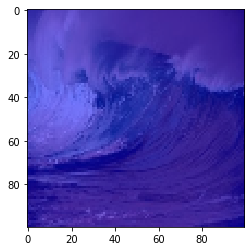

In [16]:
out_grad_cam_dir = os.path.join(output_dir, 'grad_cam/test')
os.makedirs(out_grad_cam_dir, exist_ok=True)

for i,x in tqdm(enumerate(d_cls.X_test)):
                
    # 50枚ごとにモデル再ロード
    if i % 50 == 0:
        keras.backend.clear_session() # セッションのクリア
        keras.backend.set_learning_phase(0) # Test時には0にセット DropoutやBatchNormありmodelのときはロード前にこれがないとGradCamエラーになる
        model = keras.models.load_model(os.path.join(output_dir, 'val_loss_best.h5'), compile=False) # モデルロード
    
    # 3次元numpy.array型の画像データ（*1./255.前）
    #x = x*255.0

    # ファイル名
    input_img_name = str(i).zfill(4)
    
    # 正解ラベル
    y_true = d_cls.y_test[i]

    layer_name = grad_cam.get_last_conv_layer_name(model)
    
    # 1画像について各タスクのGradCamを計算
    grad_cam_img = grad_cam.nobranch_multi_grad_cam(model, out_grad_cam_dir, input_img_name, x, y_true, layer_name, is_gradcam_plus=False)
    
    if i == 10:
        break
    
# 確認用に1枚表示
plt.figure(figsize=(6, 4))
plt.imshow(grad_cam_img)
plt.show()

Num_Images:  590


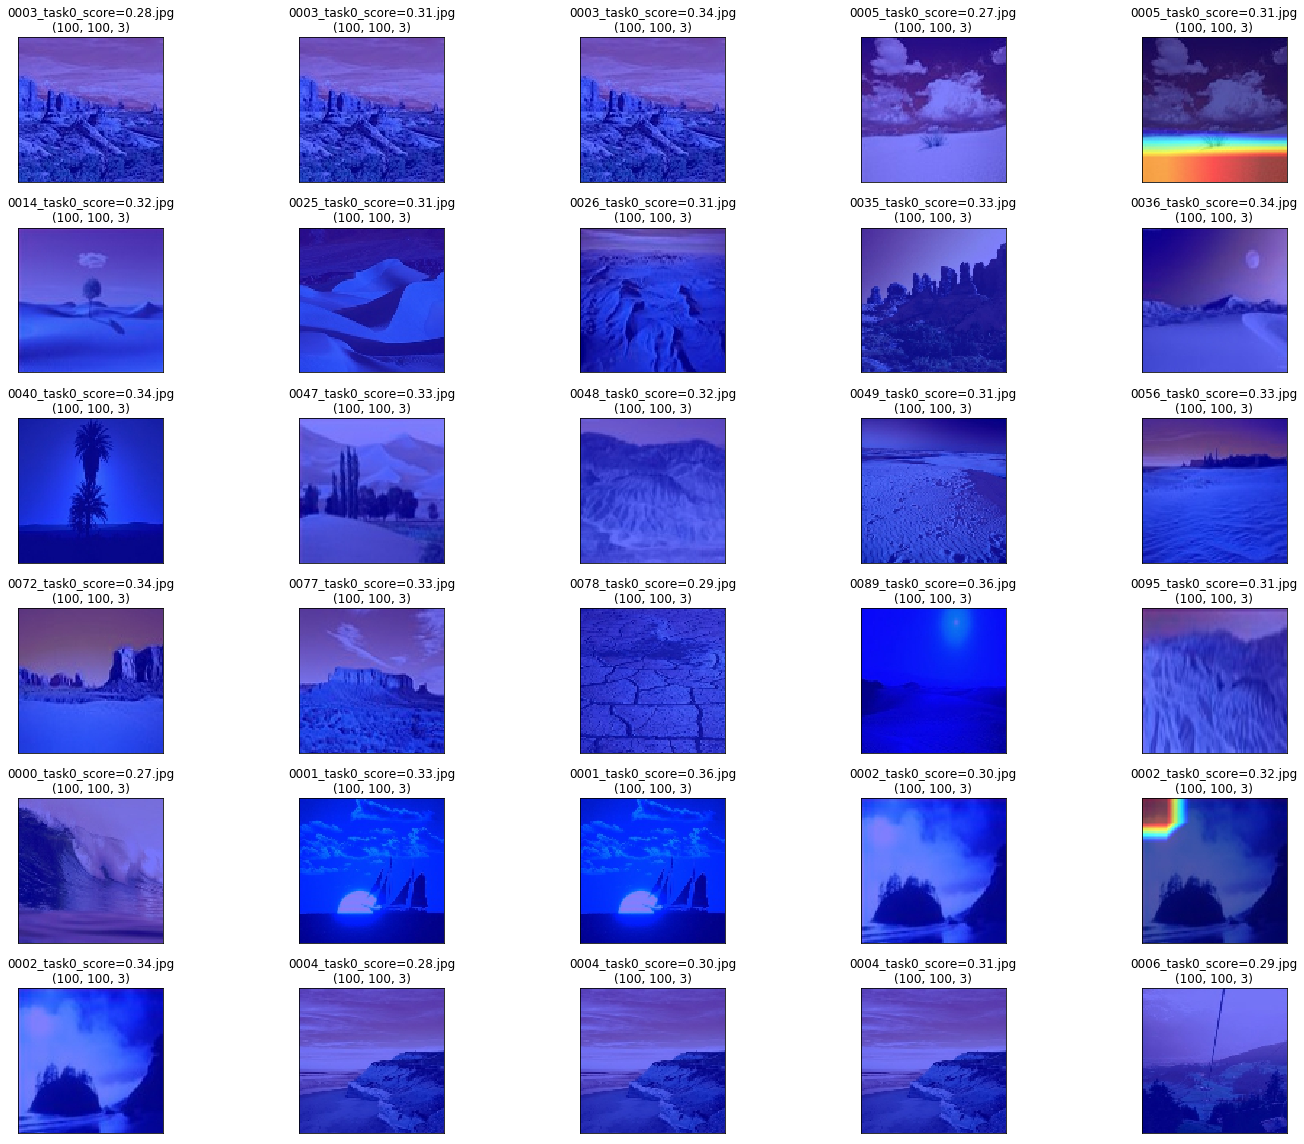

<Figure size 432x288 with 0 Axes>

In [17]:
img_list = util.find_img_files(out_grad_cam_dir)
num = 30
util.plot_5imgs(img_list
                , plot_num=num
                , figsize=(10*2, 8*2)
                , labels=[str(pathlib.Path(p).name) for p in img_list[:num]])